In [2]:
# Auto reload modules
%load_ext autoreload
%autoreload all

In [3]:
import os
from typing import List
import numpy as np
from numpy.linalg import LinAlgError
import pandas as pd
from pprint import pprint
import copy
from tqdm.notebook import tqdm

from weac.analysis import Analyzer, CriteriaEvaluator, CoupledCriterionResult, SSERRResult
from weac.core.system_model import SystemModel
from weac.components import ModelInput, Segment, ScenarioConfig, WeakLayer, Layer, CriteriaConfig
from weac.utils.snowpilot_parser import SnowPilotParser, convert_to_mm, convert_to_deg

In [4]:
# Process multiple files
file_paths = []
for directory in os.listdir("data/snowpits"):
    for file in os.listdir(f"data/snowpits/{directory}"):
        if file.endswith(".xml"):
            file_paths.append(f"data/snowpits/{directory}/{file}")

paths: List[str] = []
parsers: List[SnowPilotParser] = []

for file_path in file_paths:
    snowpilot_parser = SnowPilotParser(file_path)
    paths.append(file_path)
    parsers.append(snowpilot_parser)

print(f"\nFound {len(paths)} files")



KeyboardInterrupt: 

In [ ]:
pits_near_avalanche: List[SnowPilotParser] = []
for parser in parsers:
    # Avalanche pits
    if parser.snowpit.core_info.location.pit_near_avalanche:
        # print(parser.snowpit.core_info.location.pit_near_avalanche_location)
        pits_near_avalanche.append(parser)

print(f"\nFound {len(pits_near_avalanche)} pits near avalanche")

avalanche_pits_with_layer_of_concern: List[SnowPilotParser] = []
for pit in pits_near_avalanche:
    if pit.snowpit.snow_profile.layer_of_concern:
        # print(pit.snowpit.snow_profile.layer_of_concern)
        avalanche_pits_with_layer_of_concern.append(pit)

print(f"\nFound {len(avalanche_pits_with_layer_of_concern)} pits near avalanche with layer of concern")



Found 945 pits near avalanche

Found 848 pits near avalanche with layer of concern


In [ ]:
pit_info_list = []
for pit in avalanche_pits_with_layer_of_concern:
    depth_top = pit.snowpit.snow_profile.layer_of_concern.depth_top
    if depth_top:
        depth_top_mm = depth_top[0] * convert_to_mm[depth_top[1]]
    else:
        depth_top_mm = None
    thickness = pit.snowpit.snow_profile.layer_of_concern.thickness
    if thickness:
        thickness_mm = thickness[0] * convert_to_mm[thickness[1]]
    else:
        thickness_mm = None
    slope_angle = pit.snowpit.core_info.location.slope_angle
    if slope_angle:
        slope_angle_deg = slope_angle[0] * convert_to_deg[slope_angle[1]]
    else:
        slope_angle_deg = 0.0
    hs = pit.snowpit.snow_profile.hs
    if hs:
        hs_mm = hs[0] * convert_to_mm[hs[1]]
    else:
        hs_mm = None
    profile_depth = pit.snowpit.snow_profile.profile_depth
    if profile_depth:
        profile_depth_mm = profile_depth[0] * convert_to_mm[profile_depth[1]]
    else:
        profile_depth_mm = None
    pit_near_avalanche_location = pit.snowpit.core_info.location.pit_near_avalanche_location
    pit_info_dict = {
        "Slope Angle": slope_angle_deg,
        "HS": hs_mm,
        "Profile Depth": profile_depth_mm,
        "Pit Near Avalanche Location": pit_near_avalanche_location,
        "WL_Depth": depth_top_mm,
        "WL_Thickness": thickness_mm,
    }
    pit_info_list.append(pit_info_dict)

print(pit_info_list)

[{'Slope Angle': '23', 'HS': None, 'Profile Depth': 1000.0, 'Pit Near Avalanche Location': 'crown', 'WL_Depth': 800.0, 'WL_Thickness': 10.0}, {'Slope Angle': '42', 'HS': 930.0, 'Profile Depth': 930.0, 'Pit Near Avalanche Location': 'crown', 'WL_Depth': 390.0, 'WL_Thickness': 10.0}, {'Slope Angle': '28', 'HS': 1350.0, 'Profile Depth': 1350.0, 'Pit Near Avalanche Location': 'crown', 'WL_Depth': 300.0, 'WL_Thickness': 10.0}, {'Slope Angle': '24', 'HS': 740.0, 'Profile Depth': 740.0, 'Pit Near Avalanche Location': 'flank', 'WL_Depth': 480.0, 'WL_Thickness': 260.0}, {'Slope Angle': '28', 'HS': 2000.0, 'Profile Depth': 1250.0, 'Pit Near Avalanche Location': 'flank', 'WL_Depth': 90.0, 'WL_Thickness': 290.0}, {'Slope Angle': '27', 'HS': 1750.0, 'Profile Depth': 1750.0, 'Pit Near Avalanche Location': 'flank', 'WL_Depth': 1170.0, 'WL_Thickness': 10.0}, {'Slope Angle': '38', 'HS': 710.0, 'Profile Depth': 710.0, 'Pit Near Avalanche Location': 'crown', 'WL_Depth': 350.0, 'WL_Thickness': 10.0}, {'Sl

In [ ]:
# Setup standard values
wl_spacing = 50 # mm
phi = 0.0
standard_scenario_config = ScenarioConfig(system_type="skier", phi=phi)
standard_weak_layer = WeakLayer(rho=125, h=20, E=1.0, sigma_c=6.16, tau_c=5.09)
standard_segments = [
    Segment(length=10000, has_foundation=True, m=0.0),
    Segment(
        length=10000,
        has_foundation=True,
        m=0.0,
    ),
]
standard_criteria_config = CriteriaConfig()
standard_criteria_evaluator = CriteriaEvaluator(standard_criteria_config)

In [ ]:
def eval_avalanche_pit(parser: SnowPilotParser, pit_info_dict: dict, scenario_config: ScenarioConfig, segments: list[Segment], weaklayer: WeakLayer):
    # Extract layers
    layers, density_method = parser.extract_layers()
    heights = np.cumsum([layer.h for layer in layers])
    
    wl_depth = pit_info_dict["WL_Depth"]
    mask = heights <= wl_depth
    new_layers = [layer for layer, keep in zip(layers, mask) if keep]
    # Add truncated layer if needed
    depth = np.sum([layer.h for layer in new_layers]) if new_layers else 0.0
    if depth < wl_depth:
        additional_layer = copy.deepcopy(layers[len(new_layers) if new_layers else 0])
        additional_layer.h = wl_depth - depth
        new_layers.append(additional_layer)
    
    try:
        model_input = ModelInput(
            weak_layer=weaklayer,
            layers=new_layers,
            scenario_config=scenario_config,
            segments=segments,
        )
        system = SystemModel(model_input=model_input)
        
        cc_result: CoupledCriterionResult = standard_criteria_evaluator.evaluate_coupled_criterion(system, print_call_stats=False)
        sserr_result: SSERRResult = standard_criteria_evaluator.evaluate_SSERR(system, vertical=False, print_call_stats=False)

        pit_info_dict["impact_criterion"] = cc_result.initial_critical_skier_weight
        pit_info_dict["coupled_criterion"] = cc_result.critical_skier_weight
        pit_info_dict["sserr_result"] = sserr_result.SSERR
        pit_info_dict["touchdown_distance"] = sserr_result.touchdown_distance
    except Exception as e:
        print(f"Error processing pit {parser.snowpit.core_info.pit_id}: {e}")
        raise e
        
    return pit_info_dict, layers, weaklayer

In [ ]:
data_rows = []
error_pits = []
for pit, pit_info_dict in tqdm(zip(avalanche_pits_with_layer_of_concern, pit_info_list), total=len(avalanche_pits_with_layer_of_concern), desc="Processing avalanche pits"):
    scenario_config = ScenarioConfig(
        phi=pit_info_dict["Slope Angle"],
        system_type="skier",
    )
    try:
        pit_info_dict, layers, weaklayer = eval_avalanche_pit(
            pit, 
            pit_info_dict, 
            scenario_config, 
            standard_segments, 
            standard_weak_layer)
        data_rows.append(pit_info_dict)
    except Exception as e:
        error_pits.append(pit)
        print(f"Error processing pit {pit.snowpit.core_info.pit_id}: {e}")
        continue

print(f"Number of pits with errors: {len(error_pits)}")
print(f"Number of pits processed: {len(data_rows)}")
print(f"Number of pits total: {len(avalanche_pits_with_layer_of_concern)}")

df = pd.DataFrame(data_rows)
print(df.head())

Processing avalanche pits:   0%|          | 0/848 [00:00<?, ?it/s]

In [ ]:
df.to_csv("data/crown_flank_dataset.csv", index=False)


In [ ]:
sserr_median = df["sserr_result"].median()
sserr_mean = df["sserr_result"].mean()
sserr_std = df["sserr_result"].std()

print(f"SSERR Median: {sserr_median}")
print(f"SSERR Mean: {sserr_mean}")
print(f"SSERR Std: {sserr_std}")

cc_median = df["coupled_criterion"].median()
cc_mean = df["coupled_criterion"].mean()
cc_std = df["coupled_criterion"].std()

print(f"CC Median: {cc_median}")
print(f"CC Mean: {cc_mean}")
print(f"CC Std: {cc_std}")

SSERR Median: 4.915874695541406
SSERR Mean: 5.553898422948149
SSERR Std: 3.3576420463450023
CC Median: 213.85094701750222
CC Mean: 215.83307179093745
CC Std: 103.73382335856874


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df["WL_Depth"], y=df["impact_criterion"], mode="markers", name="Impact Criterion", marker=dict(color="red")))
fig.update_layout(xaxis_title="WL Depth (mm)", yaxis_title="Impact Criterion")
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df["WL_Depth"], y=df["coupled_criterion"], mode="markers", name="Coupled Criterion", marker=dict(color="blue")))
fig.update_layout(xaxis_title="WL Depth (mm)", yaxis_title="Coupled Criterion")
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df["WL_Depth"], y=df["sserr_result"], mode="markers", name="SSERR", marker=dict(color="green")))
fig.update_layout(xaxis_title="WL Depth (mm)", yaxis_title="SSERR")
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df["WL_Depth"], y=df["touchdown_distance"], mode="markers", name="Touchdown Distance", marker=dict(color="yellow")))
fig.update_layout(xaxis_title="WL Depth (mm)", yaxis_title="Touchdown Distance")
fig.show()


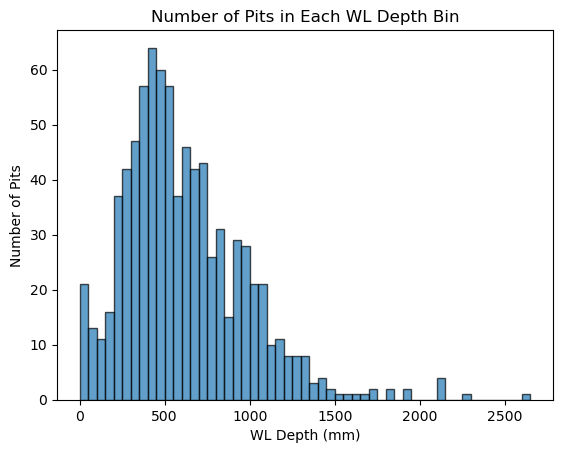

In [ ]:
import matplotlib.pyplot as plt

# Bin wl depths according to 10 mm intervals
wl_depths = df["WL_Depth"]
max_wl_depth = max(wl_depths)
min_wl_depth = min(wl_depths)

# Create bins
bin_width = 50
bins = np.arange(min_wl_depth, max_wl_depth + bin_width, bin_width)

# Use matplotlib's histogram which handles this automatically
plt.hist(wl_depths, bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel("WL Depth (mm)")
plt.ylabel("Number of Pits")
plt.title("Number of Pits in Each WL Depth Bin")
plt.show()

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

df = pd.read_csv("data/crown_flank_dataset.csv")

wl_depths = df["WL_Depth"]
df = df[df["WL_Depth"] > 150]

# Plot cumulative distribution of coupled criterion
weight = np.arange(0, 600, 10)
cc = df["coupled_criterion"][~np.isnan(df["coupled_criterion"])]
sorted_cc = np.sort(cc)
cdf = np.arange(1, len(sorted_cc) + 1) / len(sorted_cc)

fig = go.Figure()
fig.add_trace(go.Scatter(x=sorted_cc, y=cdf, mode="markers", name="Coupled Criterion", marker=dict(color="red")))
fig.update_layout(xaxis_title="Weight (kg)", yaxis_title="Cumulative Distribution")
fig.show()


In [20]:
from scipy import stats

# Fit a normal distribution to the data
params_norm = stats.norm.fit(cc)
cdf_values_norm = stats.norm.cdf(sorted_cc, *params_norm)

# Fit a log-normal distribution to the data
params_lognorm = stats.lognorm.fit(cc)
cdf_values_lognorm = stats.lognorm.cdf(sorted_cc, *params_lognorm)
print(params_lognorm)

# # Fit an exponential distribution to the data
# params_expon = stats.expon.fit(cc)
# cdf_values_expon = stats.expon.cdf(sorted_cc, *params_expon)

# Fit an Exponential Normal distribution to the data
params_exponnorm = stats.exponnorm.fit(cc)
cdf_values_exponnorm = stats.exponnorm.cdf(sorted_cc, *params_exponnorm)


fig = go.Figure()
fig.add_trace(go.Scatter(x=sorted_cc, y=cdf_values_norm, mode="lines", name="Normal"))
fig.add_trace(go.Scatter(x=sorted_cc, y=cdf_values_lognorm, mode="lines", name="Lognormal"))
# fig.add_trace(go.Scatter(x=sorted_cc, y=cdf_values_expon, mode="lines", name="Exponential"))
fig.add_trace(go.Scatter(x=sorted_cc, y=cdf_values_exponnorm, mode="lines", name="Exponential Normal"))
fig.add_trace(go.Scatter(x=sorted_cc, y=cdf, mode="markers", name="Data"))
fig.show()


(np.float64(0.15844482957139105), np.float64(-414.97945938360624), np.float64(629.6501944478106))


/home/pillowbeast/.local/miniforge3/envs/weac/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6921: RuntimeWarning:

divide by zero encountered in log



In [17]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Plot cumulative distribution of coupled criterion
weight = np.arange(0, 600, 10)
sserr = df["sserr_result"][~np.isnan(df["sserr_result"])]
sorted_sserr = np.sort(sserr)
cdf = np.arange(1, len(sorted_sserr) + 1) / len(sorted_sserr)

fig = go.Figure()
fig.add_trace(go.Scatter(x=sorted_sserr, y=cdf, mode="markers", name="SSERR", marker=dict(color="red")))
fig.update_layout(xaxis_title="SSERR", yaxis_title="Cumulative Distribution")
fig.show()


In [18]:
from scipy import stats

# # Fit a normal distribution to the data
# params_norm = stats.norm.fit(sserr)
# cdf_values_norm = stats.norm.cdf(sorted_sserr, *params_norm)

# Fit a log-normal distribution to the data
params_lognorm = stats.lognorm.fit(sserr)
cdf_values_lognorm = stats.lognorm.cdf(sorted_sserr, *params_lognorm)
print(params_lognorm)

# # Fit an exponential distribution to the data
# params_expon = stats.expon.fit(sserr)
# cdf_values_expon = stats.expon.cdf(sorted_sserr, *params_expon)

# Fit an Exponential Normal distribution to the data
params_exponnorm = stats.exponnorm.fit(sserr)
cdf_values_exponnorm = stats.exponnorm.cdf(sorted_sserr, *params_exponnorm)


fig = go.Figure()
# fig.add_trace(go.Scatter(x=sorted_sserr, y=cdf_values_norm, mode="lines", name="Normal"))
fig.add_trace(go.Scatter(x=sorted_sserr, y=cdf_values_lognorm, mode="lines", name="Lognormal"))
# fig.add_trace(go.Scatter(x=sorted_sserr, y=cdf_values_expon, mode="lines", name="Exponential"))
fig.add_trace(go.Scatter(x=sorted_sserr, y=cdf_values_exponnorm, mode="lines", name="Exponential Normal"))
fig.add_trace(go.Scatter(x=sorted_sserr, y=cdf, mode="markers", name="Data"))
fig.show()


(np.float64(0.5280686622022375), 0.014795551560188675, np.float64(5.0378221832435655))
